# Ouray Parcel Susceptibility with Exposure Overlay
**Author**: Bryce A Young  
**Created**: 2025-05-15  
**Modified**: 2025-05-17  
## Overview  
In this notebook, we take outputs from the Ouray parcel susceptibility project and overlay with data from [Wildfire Risk to Communities (WRC)](https://wildfirerisk.org/download/ "Data Download"). The WRC data layer used is Risk to Potential Structures (RPS). It is described on the website as "A measure that integrates wildfire likelihood and intensity with generalized consequences to a home on every pixel." In other words, the raster contains information on hazard and exposure. By multiplying the RPS value with the susceptibility score of each home, we can gain better insights to generalized parcel risk.

This notebook follows this general workflow:  
1. Prepare raster
    - Import Ouray County boundary (EPSG:26913) and reproject to EPSG:5070 to match the RPS raster. 
    - Rasterize county geometry (using `rast_and_write` function in `utils.raster`)  
    - Use rasterized county boundary to clip the CONUS RPS raster to Ouray County  
    - Reproject clipped RPS raster to EPSG:26913  
2. Obtain RPS values at the centroid of each structure footprint, appending values to the geodataframe. 
3. Explore results  

## Set Up Environment

In [3]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# rps path
rps_path = r"D:\_DATA\WRC\RPS_CONUS_2020\RPS_CONUS"
# output folder for clipped RPS raster
risk = os.path.join(data, 'risk')
# county boundary folder
geoms = os.path.join(data, 'county_geoms')

## Prepare Raster
### **1** Reproject and rasterize county boundary

<Axes: >

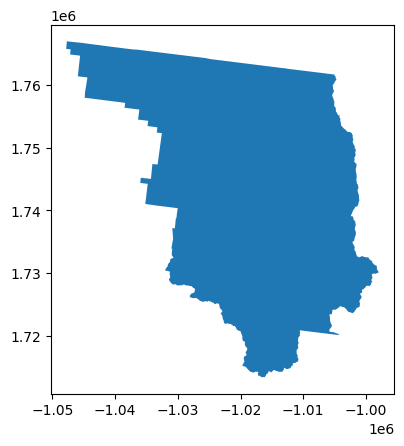

In [27]:
import geopandas as gpd

county = gpd.read_file(os.path.join(geoms, 'county_WKID26913.gpkg'))
county_5070 = county.to_crs(5070)

county_5070.plot()

Now we use the `rast_and_write` function, but we will have to create a new profile for the raster since we don't have a source profile to draw from.

In [28]:
from utils.rasterize import make_prof

county_prof_30m = make_prof(county_5070, resolution=30)
county_prof_30m

INFO: CRS was not specified. Using CRS from GeoDataFrame by default.


{'driver': 'GTiff',
 'height': 1786,
 'width': 1662,
 'count': 1,
 'dtype': 'uint8',
 'crs': <Projected CRS: EPSG:5070>
 Name: NAD83 / Conus Albers
 Axis Info [cartesian]:
 - X[east]: Easting (metre)
 - Y[north]: Northing (metre)
 Area of Use:
 - name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
 - bounds: (-124.79, 24.41, -66.91, 49.38)
 Coordinate Operation:
 - name: Conus Albers
 - method: Albers Equal Area
 Datum: North American Datum 1983
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich,

In [29]:
from utils.rasterize import rast_and_write

county_rast_30m = rast_and_write(
    county_5070,
    os.path.join(geoms, 'county_WKID5070_30m.tif'),
    profile=county_prof_30m
)

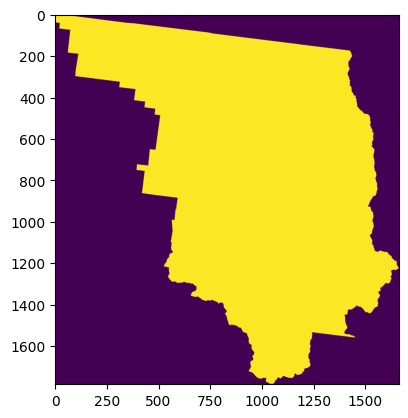

In [30]:
from utils.raster import read_raster
import matplotlib.pyplot as plt

county_rast_30m = read_raster(os.path.join(geoms, 'county_WKID5070_30m.tif'), layer=1)
plt.imshow(county_rast_30m)

### **2** Clip National RPS to County Boundary

In [ ]:
import numpy as np
import rasterio as rio
from utils.raster import read_raster
from rasterio.warp import reproject, Resampling

# Read in national RPS data
rps, rps_prof = read_raster(os.path.join(rps_path, 'RPS_CONUS.tif'), layer=1, profile=True)

# Create an empty array for RPS reprojected to county grid
rps_resampled = np.full_like(county_rast_30m, fill_value=rps_prof['nodata'], dtype=rps.dtype)

# Reproject RPS to match county grid
reproject(
    source=rps,
    destination=rps_resampled,
    src_transform=rps_prof['transform'],
    src_crs=rps_prof['crs'],
    dst_transform=county_prof_30m['transform'],
    dst_crs=county_prof_30m['crs'],
    resampling=Resampling.nearest  
)


# Populate new array with RPS data where county raster == 1
rps_county = np.where(county_rast_30m == 1, rps_resampled, rps_prof['nodata'])

# Save to new file
out_profile = rps_prof.copy()
out_profile.update({
    'height': rps_county.shape[0],
    'width': rps_county.shape[1],
    'transform': county_prof_30m['transform'],
    'crs': county_prof_30m['crs'],
    'compress': 'lzw'
})
with rio.open(os.path.join(risk, 'RPS_30m_5070.tif'), 'w', **out_profile) as dst:
    dst.write(rps_county, 1)

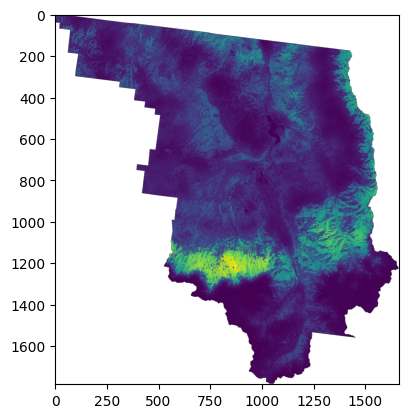

In [ ]:
rps_county[rps_county == -9999] = np.nan

plt.imshow(rps_county)

### **3** Reproject RPS to 26913 to match other county data

INFO: CRS was not specified. Using CRS from GeoDataFrame by default.


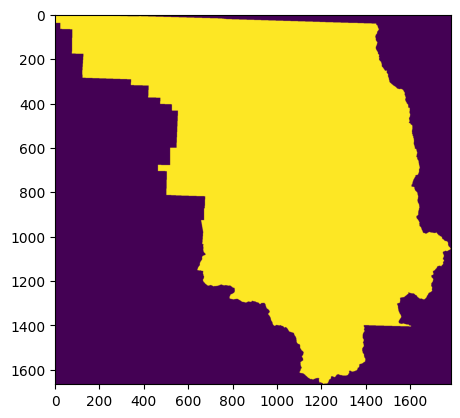

In [ ]:
# Clear this big kahoona from memory
del rps

# This is already defined but let's re-import anyways
county = gpd.read_file(os.path.join(geoms, 'county_WKID26913.gpkg'))
# Make profile
from utils.rasterize import make_prof
county_prof_30m_26913 = make_prof(county, resolution=30)
# Rasterize and write to new file
from utils.rasterize import rast_and_write
county_rast_30m_26913 = rast_and_write(
    county,
    os.path.join(geoms, 'county_WKID26913_30m.tif'),
    profile=county_prof_30m_26913
)
plt.imshow(county_rast_30m_26913)

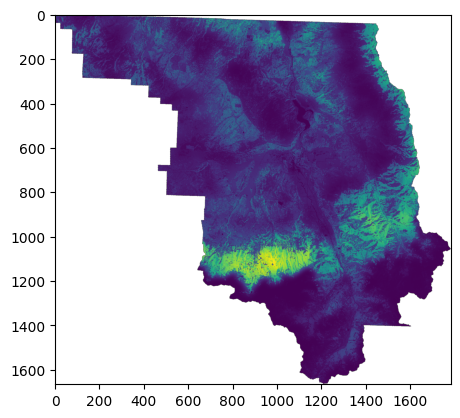

In [ ]:
from rasterio.warp import reproject, Resampling

# Set shape and dtype from county 26913 raster
dst_shape = (county_prof_30m_26913['height'], county_prof_30m_26913['width'])
rps_26913 = np.full(dst_shape, rps_prof['nodata'], dtype=rps_county.dtype)

reproject(
    source=rps_county,
    destination=rps_26913,
    src_transform=county_prof_30m['transform'],  # original raster's transform
    src_crs=county_prof_30m['crs'],              # original raster's CRS
    dst_transform=county_prof_30m_26913['transform'],
    dst_crs=county_prof_30m_26913['crs'],
    resampling=Resampling.nearest  # or bilinear if you want smooth transitions
)

rps_masked = np.where(
    county_rast_30m_26913 == 1,
    rps_26913,
    rps_prof['nodata']
)

rps_masked[rps_masked == rps_prof['nodata']] = np.nan
plt.imshow(rps_masked)

In [ ]:
rps_masked[np.isnan(rps_masked)] = -9999.0

out_profile.update({
    'transform': county_prof_30m_26913['transform'],
    'crs': county_prof_30m_26913['crs'],
    'height': county_prof_30m_26913['height'],
    'width': county_prof_30m_26913['width']
})

with rio.open(os.path.join(risk, 'RPS_30m_26913.tif'), 'w', **out_profile) as dst:
    dst.write(rps_masked, 1)

## Append RPS values to GDF

In [6]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import rasterio as rio
from utils.raster import read_raster
out = os.path.join(data, '_out')

# Import data
rps, rps_prof = read_raster(os.path.join(risk, 'RPS_30m_26913.tif'), layer=1, profile=True)
gdf = gpd.read_file(os.path.join(out, 'clusters.gpkg'))

# Extract RPS values at structure locations
from rasterio.transform import rowcol
x = gdf.geometry.x
y = gdf.geometry.y
rows, cols = rowcol(rps_prof['transform'], x, y)
gdf["rps"] = rps[rows, cols]
gdf.head()

,rwra_index,PARCELNB,tax_WBL,tax_DGR,tax_PTO,tax_OPP,fc2m,fc4m,fc8m,fc8m+,intsc_class,acre_class,sqft_class,ssd_class,eyb_class,wui_class_1,wui_class_3,wui_class_5,wui_class_6,tax_EXW_CONC/MSNRY,tax_EXW_WOOD,tax_RCVR_WOOD,tax_RSTR_GABLE,tax_RSTR_MULTI_PEAK,Risk_Rating,Risk_Rating_new,cluster_dbscan,geometry,rps
0,5.0,403935100181.0,1.0,1.0,3.0,3.0,2,3,1,0,0,5,3,3,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,0,POINT (252995.437 4241729.295),0.046641
1,6.0,403926423002.0,2.0,1.0,1.0,2.0,1,1,1,1,0,4,2,3,4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Low,Low,1,POINT (253043.842 4242576.202),0.051093
2,7.0,403926300151.0,1.0,1.0,1.0,1.0,1,3,3,0,1,1,2,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Low,Low,5,POINT (252852.699 4242304.895),0.059946
3,8.0,403936300089.0,1.0,1.0,1.0,1.0,1,2,1,1,1,5,2,2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Moderate,Moderate,1,POINT (253690.349 4240864.501),0.096121
4,9.0,403935200086.0,1.0,1.0,1.0,2.0,1,2,2,0,0,5,2,3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Low,Low,2,POINT (252706.517 4241700.068),0.054491


In [7]:
gdf.to_file(os.path.join(out, 'clusters_risk.gpkg'), driver='GPKG', index=False)

## Analyze Results
First we will get an idea of the distribution of RPS values per risk class. Then we will multiply RPS values by risk scores (1=Low, 2=Moderate, 3=High, 4=Very High, 5=Extreme) to obtain a value for susceptibility multiplied by hazard and exposure.

In [8]:
# Create int column for risk ratings
mapping = {
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Very High': 4,
    'Extreme': 5
}

gdf['Rating_Score'] = gdf['Risk_Rating'].map(mapping).fillna(1).astype('uint8')
# Create column multiplying risk ratings by rps
gdf['RPS*RiskRating'] = gdf['rps'] * gdf['Rating_Score']

# Save to file for mapping in ArcGIS
gdf.to_file(os.path.join(out, 'clusters_risk.gpkg'), driver='GPKG', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_60176\2220840119.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gdf, x='Risk_Rating', y='rps', order=order, palette='flare', showfliers=False)


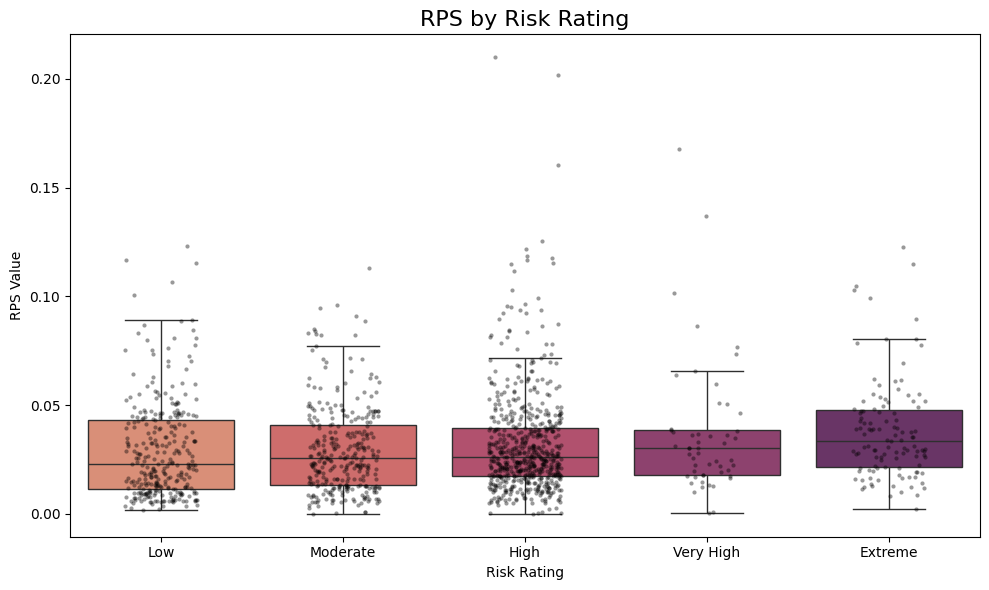

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# # Set the style
# sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
order = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']
# Boxplot
sns.boxplot(data=gdf, x='Risk_Rating', y='rps', order=order, palette='flare', showfliers=False)
# Jittered points
sns.stripplot(data=gdf, x='Risk_Rating', y='rps', order=order, color='black', alpha=0.4, jitter=0.2, size=3)

# Labels and title
plt.title("RPS by Risk Rating", fontsize=16)
plt.xlabel("Risk Rating")
plt.ylabel("RPS Value")

plt.tight_layout()
plt.show()

The plot shows minor differences in mean rps value per risk rating, although it is worth noting that as risk rating increases, so does the mean rps. This would indicate that homes that recieve a higher risk rating in the field are also more likely to be exposed to wildfire. The relationship could be causal, meaning that the risk ratings incorporate exposure and are therefore capturing similar data to RPS. Or the relationship could be happenstantial, meaning that more susceptible homes are also more likely to be exposed to wildfire.

## Conclusion
This concludes this minor analysis. By viewing structure susceptibility and hazard/exposure together on a map, community managers and grant writers can prioritize defensible space and home hardening in areas where susceptibility and exposure are both high.

Insurance companies are also interested in this view of risk, especially in California. They are interested in broader hazard and exposure to communities and homes. They are also interested in the susceptibility of each home, irrespective of the likelihood of wildfire occurrence. Homes with higher exposure should be prioritized for hardening and should be incentivized by insurance providers to increase the level of hardening where exposure is greater. Homes on smaller parcels and with more neighboring structures should be prioritized for home hardening because they cannot control all the available fuels that may expose them to wildfire. On the other hard, isolated structures closer to the wildlands and without neighboring structures within the defensible space should prioritize creating defensible space.

The data used in this project can be used to identify these structure classes.

![Homes Labeled by RPS * susceptibility over RPS raster](../figures/suscept_rps.jpg)